In [1]:
import pandas as pd
import sys
sys.path.append('../')
from data_preprocessing import Preprocess

#word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


#sgdclssifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import numpy as np

In [2]:
df=pd.read_csv('../../data/dialects_data.csv')

#preprocess
preprocess = Preprocess(df)
cleaned_df=preprocess.preprocess()



In [3]:
Word2VecModel = Word2Vec(vector_size=300, window=5, min_count=1, workers=4)
Word2VecModel.build_vocab(cleaned_df['text'].apply(lambda x: x.split()))
Word2VecModel.train(cleaned_df['text'].apply(lambda x: x.split()), total_examples=Word2VecModel.corpus_count, epochs=30)


(56308377, 60344460)

In [4]:
Embedding = Word2VecModel.wv


In [5]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return pd.DataFrame([np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                                     or [np.zeros(self.dim)], axis=0) for words in X])

In [7]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict


In [8]:
class tfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 300

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return pd.DataFrame([np.mean([self.word2vec[w] * self.word2weight[w]
                                      for w in words if w in self.word2vec] or
                                     [np.zeros(self.dim)], axis=0) for words in X])

In [9]:
def save_embedding_model(Word2VecModel, path):
    Word2VecModel.wv.save_word2vec_format(path, binary=False)
    
def load_embedding_model(path):
    return KeyedVectors.load_word2vec_format(path, binary=False)

In [19]:
w2v=load_embedding_model('../../models/word2vec_model.txt')

In [10]:
#train sgdclassifier
X = cleaned_df['text']
y = cleaned_df['dialect']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
sgd=SGDClassifier()
sgd.fit(MeanEmbeddingVectorizer(Embedding).transform(X_train), y_train)
y_pred=sgd.predict(MeanEmbeddingVectorizer(Embedding).transform(X_test))


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

In [13]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))

Accuracy:  0.4157387036723642
F1 score:  0.3282879777712843


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

In [14]:
confusion_matrix(y_test, y_pred)

c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

array([[9551, 1611,  306,    0,   16],
       [3341, 2036,  185,    1,   15],
       [4728, 1841,  683,    3,   13],
       [1592,  496,  180,    6,    9],
       [2148,  658,  119,    0,    7]], dtype=int64)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

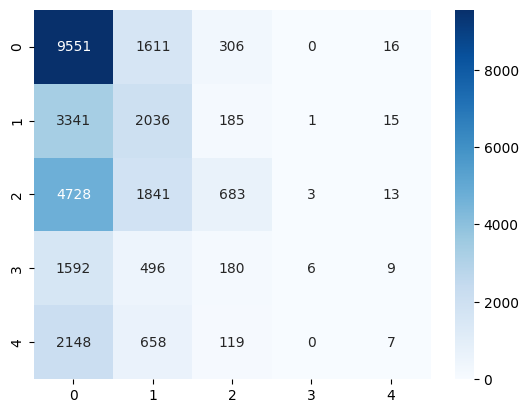

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [17]:
save_embedding_model(Word2VecModel, '../../models/word2vec_model.txt')

In [18]:
import joblib

joblib.dump(sgd, '../../models/sgd_model.pkl')

['../../models/sgd_model.pkl']

In [25]:
sgd=SGDClassifier(loss='squared_hinge', max_iter=3000, penalty='elasticnet', alpha=0.001, learning_rate='optimal')

In [26]:
sgd.fit(MeanEmbeddingVectorizer(Embedding).transform(X_train), y_train)

c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

In [ ]:
joblib.dump(sgd, '../../models/sgd_model_meanEMBD.pkl')

In [ ]:
y_pred=sgd.predict(MeanEmbeddingVectorizer(Embedding).transform(X_test))

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))

confusion_matrix(y_test, y_pred)


In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [ ]:
sgd.fit(tfidfEmbeddingVectorizer(Embedding).transform(X_train), y_train)

c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\zacks\anaconda3\envs\DataTraining\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
y_pred=sgd.predict(tfidfEmbeddingVectorizer(Embedding).transform(X_test))

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))



In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [ ]:
joblib.dump(sgd, '../../models/best_sgd_model_TFIDF.pkl')